In [1]:
import os
from IPython.display import Image as ipy_image
from IPython.display import display

from utils.demo_util import get_shape_comp_model, get_shape_comp_opt, make_dummy_batch
from utils.qual_util import load_bert2vqsc_model, get_lang_prob, save_mesh_as_gif
from utils.util import seed_everything
from utils.util_3d import init_mesh_renderer, sdf_to_mesh

%reload_ext autoreload
%autoreload 2

In [2]:
seed_everything(111)

res_dir = 'results'
if not os.path.exists(res_dir): os.makedirs(res_dir)

gpu_id = 0
nimgs=6

In [4]:
opt = get_shape_comp_opt(gpu_id=gpu_id)
opt.dataset_mode = "text2shape"
model = get_shape_comp_model(opt)    
model.eval()

""" setup renderer """
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

opt.mlp_layers = 3
opt.mlp_hidden = 1024
bert2vq = load_bert2vqsc_model(opt)

[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: /home/fslsegment/sercan/AutoSDF-Text2shape/pretrained_ckpts_text2shapepp/vqvae.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: /home/fslsegment/sercan/AutoSDF-Text2shape/pretrained_ckpts_text2shapepp/rand_tf_singles_best.pth


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([512, 6, 512])


[*] autoregressively inferencing...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:10<00:00, 50.58it/s]


torch.Size([6, 8, 8, 8])
torch.Size([512, 6, 512])


[*] autoregressively inferencing...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:10<00:00, 50.42it/s]


torch.Size([6, 8, 8, 8])
torch.Size([512, 6, 512])


[*] autoregressively inferencing...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:10<00:00, 50.79it/s]


torch.Size([6, 8, 8, 8])


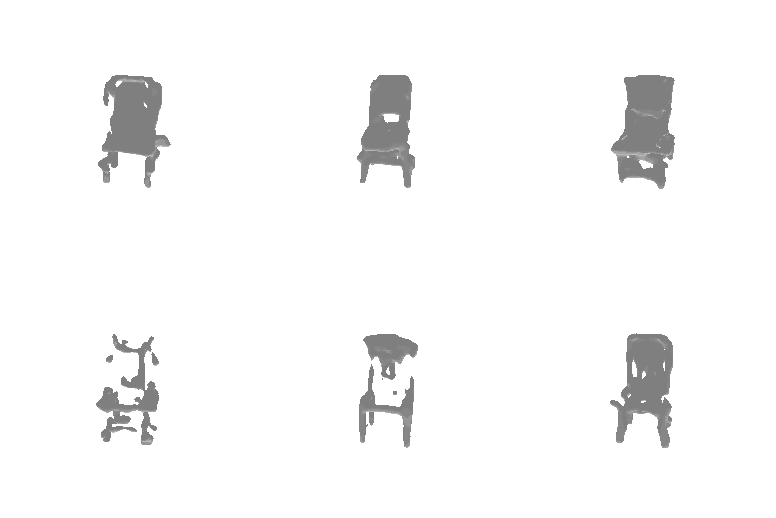

In [10]:
from datasets.dataloader import CreateDataLoader
import torch
from utils.qual_util import get_lang_prob_recursive, save_mesh_as_pics
from einops import rearrange
import pandas as pd
import json
import glob
from utils.demo_util import make_dummy_batch
with open(f'./info-shapenet.json') as f:
    info = json.load(f)

# model_list = []
# cat_to_id = info['cats']
# all_files = glob.glob(f"/home/fslsegment/sercan/shap/*/*")
# with open(f'./filelists/{cat_to_id["chair"]}_train.lst') as f:
#     lang_list_s = []
#     model_list_s = []
#     for l in f.readlines():
#         model_id = l.rstrip('\n')
#         model_list.append(model_id)
# with open(f'./filelists/{cat_to_id["chair"]}_test.lst') as f:

#     for l in f.readlines():
#         model_id = l.rstrip('\n')
#         model_list.append(model_id)
# set_zs = [p for p in all_files if "z_set" in p and p.split("/")[-2] in model_list]
# shape_zs = [p for p in all_files if "z" in p and "set" not in p and p.split("/")[-2] in model_list]
# set2path = {p.split("/")[-1].split("_")[-1].replace(".pt", ""): p for p in set_zs}
# print(list(set2path.keys())[:10])
# mod2code_path = {p.split("/")[-2]: p for p in shape_zs}
# text2shapepp = pd.read_csv('./similar_phrase_2.csv')
# with open("file.json", 'r') as f:
#     all_id_list = json.load(f)
# sequences = all_id_list
# model_list = []

# seq = sequences[155]
# print(seq)
# t_2_row_ind = seq[1]

# t_2_row = text2shapepp.iloc[t_2_row_ind]
# t_2_text = t_2_row["phrase_texts"]
# t_2_row = text2shapepp.iloc[t_2_row_ind]
# t_2_code = torch.load(set2path[str(t_2_row_ind)], map_location="cpu")
# print(t_2_text)
z1 = torch.full((6,8,8,8,512), 1/512).cuda()
# last_text = ""

prompts = ["a wooden chair", "with long back", "space between seat and back" ]
test_data = make_dummy_batch(nimgs)
last_text = ""
for text in prompts:
    

    text_conditional = last_text + text
    lang_conditional_prob = get_lang_prob_recursive(bert2vq, nimgs*[text_conditional], z1)
    print(lang_conditional_prob.shape)
    z1_old = rearrange(z1, 'bs d h w c -> (d h w bs) c')
    # gen_order = torch.argsort((torch.abs(lang_conditional_prob-z1_old)).sum(-1), dim=-1, descending=True)

    # lang_conditional_prob = lang_conditional_prob.repeat(1, nimgs, 1)
    topk = 10
    alpha = .7

    model.inference(test_data, topk=topk, prob=lang_conditional_prob, alpha=alpha, gen_order=None)
    sampler = torch.distributions.categorical.Categorical(z1)
    print(test_data["idx"].shape)
    gen_mesh = sdf_to_mesh(model.x_recon_tf)
    pred_probs = model.x_probs
    z1 = rearrange(pred_probs, '(d h w) bs c -> bs d h w c', d=8, h=8, w=8)

    gen_gif_name = f'{res_dir}/lang-guided-gen{text_conditional}.gif'
    save_mesh_as_pics(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)
    last_text = text_conditional + " "

for name in [gen_gif_name]:
    display(ipy_image(name))

In [16]:
torch.randperm(512, device='cuda').shape

torch.Size([512])

In [40]:
!nvidia-smi

Wed Jul  5 00:14:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   38C    P8    28W / 250W |      0MiB / 12211MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   

In [ ]:
!kill -9 30186